In [2]:
import numpy as np 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler



from sklearn.model_selection import KFold, cross_val_score

from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import accuracy_score 
from sklearn.metrics import f1_score 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

import xgboost as xgb
import shap
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import PowerTransformer

import joblib

import warnings
warnings.filterwarnings('ignore')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
data = pd.read_csv("preprocessed_data.csv")

In [4]:
df = data.copy()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35295 entries, 0 to 35294
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   GrossApproval          35295 non-null  float64
 1   SBAGuaranteedApproval  35295 non-null  float64
 2   InitialInterestRate    35295 non-null  float64
 3   TermInMonths           35295 non-null  float64
 4   BusinessAge            35295 non-null  float64
 5   GrossChargeOffAmount   35295 non-null  float64
 6   RevolverStatus         35295 non-null  float64
 7   Franchise              35295 non-null  float64
 8   loan_type              35295 non-null  object 
 9   industry               35295 non-null  object 
 10  BusinessType           35295 non-null  object 
 11  LoanStatus             35295 non-null  object 
dtypes: float64(8), object(4)
memory usage: 3.2+ MB


# Categorical encoding





In [6]:
def encoding(df):  



    # data Spliting
    X = df.drop("LoanStatus", axis= 1)
    y = df["LoanStatus"]

    X=pd.get_dummies(X, drop_first=False,dtype=int)


    # Y encoding

    # where "PIF" refers  to  non Defaulter (0)
    # where  "CHGOFF" refers to Defaulter   (1)

    y = y.replace("PIF",0)
    y = y.replace("CHGOFF",1)


    # concat

    df = pd.concat([X, y], axis=1)

    return df

In [7]:
df = encoding(df)

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35295 entries, 0 to 35294
Data columns (total 36 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   GrossApproval                                                                      35295 non-null  float64
 1   SBAGuaranteedApproval                                                              35295 non-null  float64
 2   InitialInterestRate                                                                35295 non-null  float64
 3   TermInMonths                                                                       35295 non-null  float64
 4   BusinessAge                                                                        35295 non-null  float64
 5   GrossChargeOffAmount                                                               35295 non-null  flo

In [6]:
df.LoanStatus.value_counts()

LoanStatus
0    31924
1     3371
Name: count, dtype: int64

# data Balancling

# smote

In [9]:
def smote(df):

    smote = SMOTE()

    # fit predictor and target variable
    x_smote, y_smote = smote.fit_resample(df[(i for i in list(df.describe(include='all').columns) if i != 'LoanStatus')], df['LoanStatus'])

    print('Original unbalanced dataset shape', len(df))
    print('Resampled balanced dataset shape', len(y_smote))

    balanced_df = pd.DataFrame(x_smote, columns=list(i for i in list(df.describe(include='all').columns) if i != 'LoanStatus'))

    #adding target variable to new created dataframe
    balanced_df['LoanStatus'] = y_smote

    return balanced_df

# modeling

# multi model function

In [45]:


def vanilla(df):
    LR_model = LogisticRegression()
    DT_model = DecisionTreeClassifier()
    SV_model = SVC()
    RFR_model = RandomForestClassifier()
    XGB_model = XGBClassifier()

    models = [LR_model, DT_model, SV_model, RFR_model, XGB_model]

    # Create a list to store metrics for each model
    metrics_list = []

    # Split the data into features (X) and target variable (y)
    X = df.drop('LoanStatus', axis=1)
    y = df['LoanStatus']

    # Create the training sample
    x_train, x_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.4, random_state=1)

    # Split the remaining observations into validation and test
    x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=1)

    for model in models:
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        # Make predictions on the training and validation sets
        y_train_pred = model.predict(x_train)
        y_val_pred = model.predict(x_val)

        # Collect metrics in a dictionary
        metrics = {
            'Model': model.__class__.__name__,
            'Accuracy Train': accuracy_score(y_train, y_train_pred) * 100,
            'F1 Score Train': f1_score(y_train, y_train_pred) * 100,
            'Accuracy Validation': accuracy_score(y_val, y_val_pred) * 100,
            'F1 Score Validation': f1_score(y_val, y_val_pred) * 100,
            'Accuracy Test': accuracy_score(y_test, y_pred) * 100,
            'F1 Score Test': f1_score(y_test, y_pred) * 100,
            'Confusion Matrix': confusion_matrix(y_test, y_pred),
            'Classification Report': classification_report(y_test, y_pred)
        }

        # Append the metrics dictionary to the list
        metrics_list.append(metrics)
        print('*' * 50)

    # Create a DataFrame from the list of metrics
    df_metrics = pd.DataFrame(metrics_list)
    return df_metrics



#  handling overfitting 

In [46]:
def cv_models(df):
    LR_model= LogisticRegression()
    DT_model= DecisionTreeClassifier()
    SV_model= SVC()
    RFR_model= RandomForestClassifier()
    XGB_model= XGBClassifier()

    # LR_model,DT_model,SV_model,RFR_model
    model_list=[XGB_model]


    # Split the data into features (X) and target variable (y)
    X = df.drop('LoanStatus', axis=1)
    y = df['LoanStatus']
    



    for m in model_list:
        k_folds = KFold(n_splits = 5)

        scores = cross_val_score(m, X, y, cv = k_folds)

        print("Cross Validation Scores: ",m, scores)
        print("Average CV Score: ",m, scores.mean())
        print("Number of CV Scores used in Average: ",m, len(scores))


In [47]:
df.LoanStatus.value_counts()

LoanStatus
0    31924
1     3371
Name: count, dtype: int64

# Testing


# smote + multimodel 

In [50]:
sm = smote(df)

Original unbalanced dataset shape 35295
Resampled balanced dataset shape 63848


In [51]:
result_ds = vanilla(sm)

result_ds.drop(axis=1 , columns=["Classification Report"], inplace=True)

result_ds

**************************************************
**************************************************
**************************************************
**************************************************
**************************************************


,Model,Accuracy Train,F1 Score Train,Accuracy Validation,F1 Score Validation,Accuracy Test,F1 Score Test,Confusion Matrix
0,LogisticRegression,82.431868,83.014487,82.278778,82.686864,82.983555,83.458933,"[[5115, 1284], [889, 5482]]"
1,DecisionTreeClassifier,99.942571,99.942765,95.505090,95.459579,95.606891,95.614789,"[[6093, 306], [255, 6116]]"
2,SVC,88.153910,88.542140,87.141738,87.421480,87.658575,88.018854,"[[5405, 994], [582, 5789]]"
3,RandomForestClassifier,99.942571,99.942771,96.805012,96.809509,96.679718,96.710628,"[[6113, 286], [138, 6233]]"
4,XGBClassifier,98.360656,98.371200,96.969460,96.953955,97.047768,97.058594,"[[6173, 226], [151, 6220]]"


# Interpretation of Findings
Logistic Regression: This model showed decent performance across all datasets. However, it had a relatively lower F1 score on the test set compared to other models, which suggests it may not be as effective in balancing precision and recall for this particular problem.

Decision Tree Classifier: While this model achieved high accuracy, the near-perfect scores on the training set indicate a high likelihood of overfitting. This means the model may not perform as well on new, unseen data.

SVC: The Support Vector Classifier had moderate performance metrics. It did not overfit as much as the Decision Tree but was outperformed by other models on the test set.

Random Forest Classifier: This model showed high accuracy and F1 scores with better generalization than the Decision Tree. However, the high scores on the training set suggest some overfitting.

XGBClassifier: Exhibiting the highest accuracy and F1 scores on the test set with less evidence of overfitting, the XGBClassifier appears to be the most suitable model for this application.

# final model
# XGboost

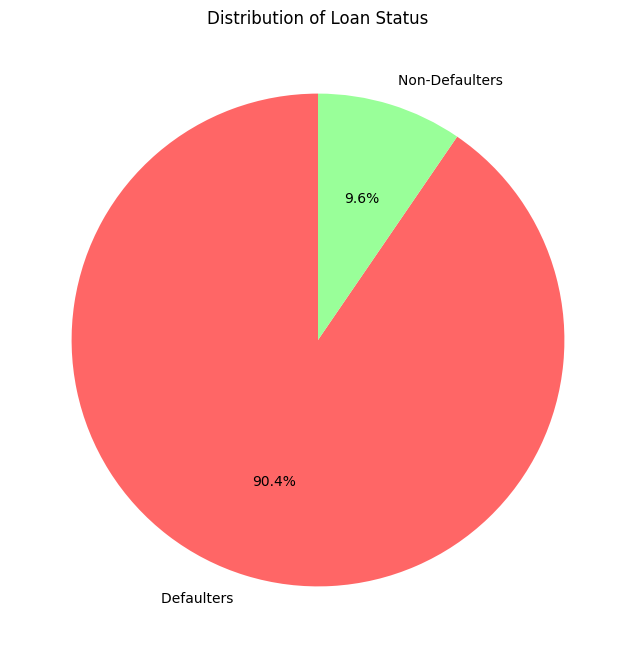

In [27]:
colors = ['#ff6666', '#99ff99']

# Plotting
plt.figure(figsize=(8, 8))
plt.pie(df['LoanStatus'].value_counts(), labels=['Defaulters ', 'Non-Defaulters '], autopct='%1.1f%%', startangle=90, colors=colors)

# Adding title
plt.title("Distribution of Loan Status")

# Display the plot
plt.show()

In [23]:
sdf = smote(df)

Original unbalanced dataset shape 35295
Resampled balanced dataset shape 63848


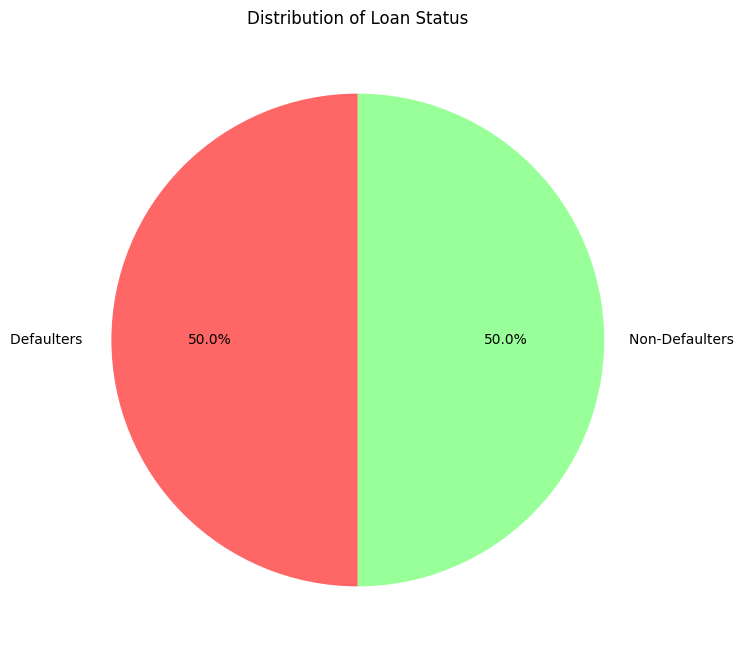

In [28]:
colors = ['#ff6666', '#99ff99']

# Plotting
plt.figure(figsize=(8, 8))
plt.pie(sdf['LoanStatus'].value_counts(), labels=['Defaulters ', 'Non-Defaulters '], autopct='%1.1f%%', startangle=90, colors=colors)

# Adding title
plt.title("Distribution of Loan Status")

# Display the plot
plt.show()

In [10]:
plt.figure(figsize=(8, 8))
plt.pie(sdf['LoanStatus'], labels=sdf['LoanStatus'], autopct='%1.1f%%', startangle=90, )

# Adding title
plt.title("Distribution of LoanStatus")

Text(0.5, 1.0, 'Distribution of LoanStatus')

In [9]:
 # Split the data into features (X) and target variable (y)
X = sdf.drop('LoanStatus', axis=1)
y = sdf['LoanStatus']

# Create the training sample
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)


In [82]:
XGB_model = XGBClassifier()
XGB_model.fit(x_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [83]:
y_pred = XGB_model.predict(x_test)

In [84]:
print('Accuracy Test : ' ,accuracy_score(y_test, y_pred) * 100)
print('F1 Score Test : ' ,f1_score(y_test, y_pred) * 100)
print('Confusion Matrix :' ,confusion_matrix(y_test, y_pred))

Accuracy Test :  96.62881754111197
F1 Score Test :  96.63685012304207
Confusion Matrix : [[12309   537]
 [  324 12370]]


Feature Importance Plot

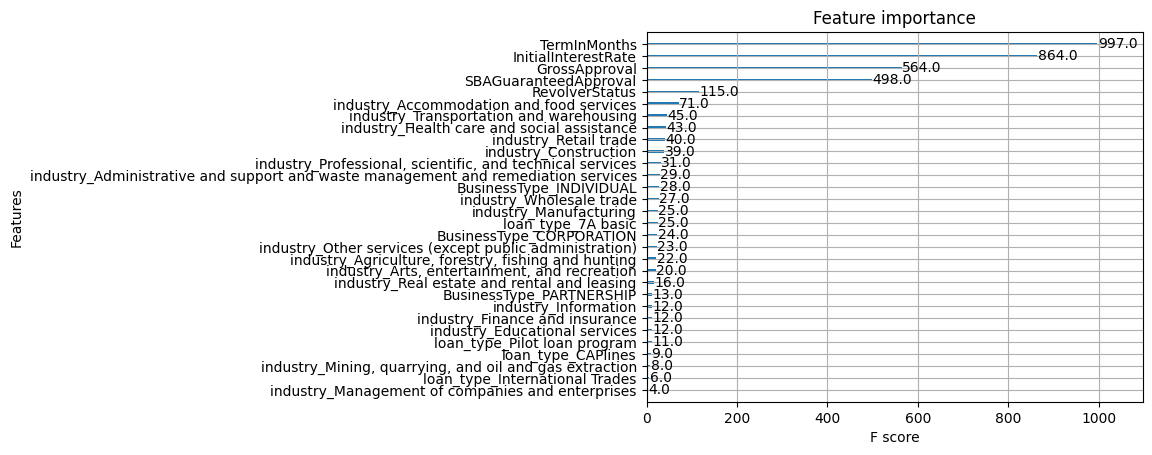

In [85]:
# Feature Importance Plot

# Plot feature importance
xgb.plot_importance(XGB_model)
plt.show()


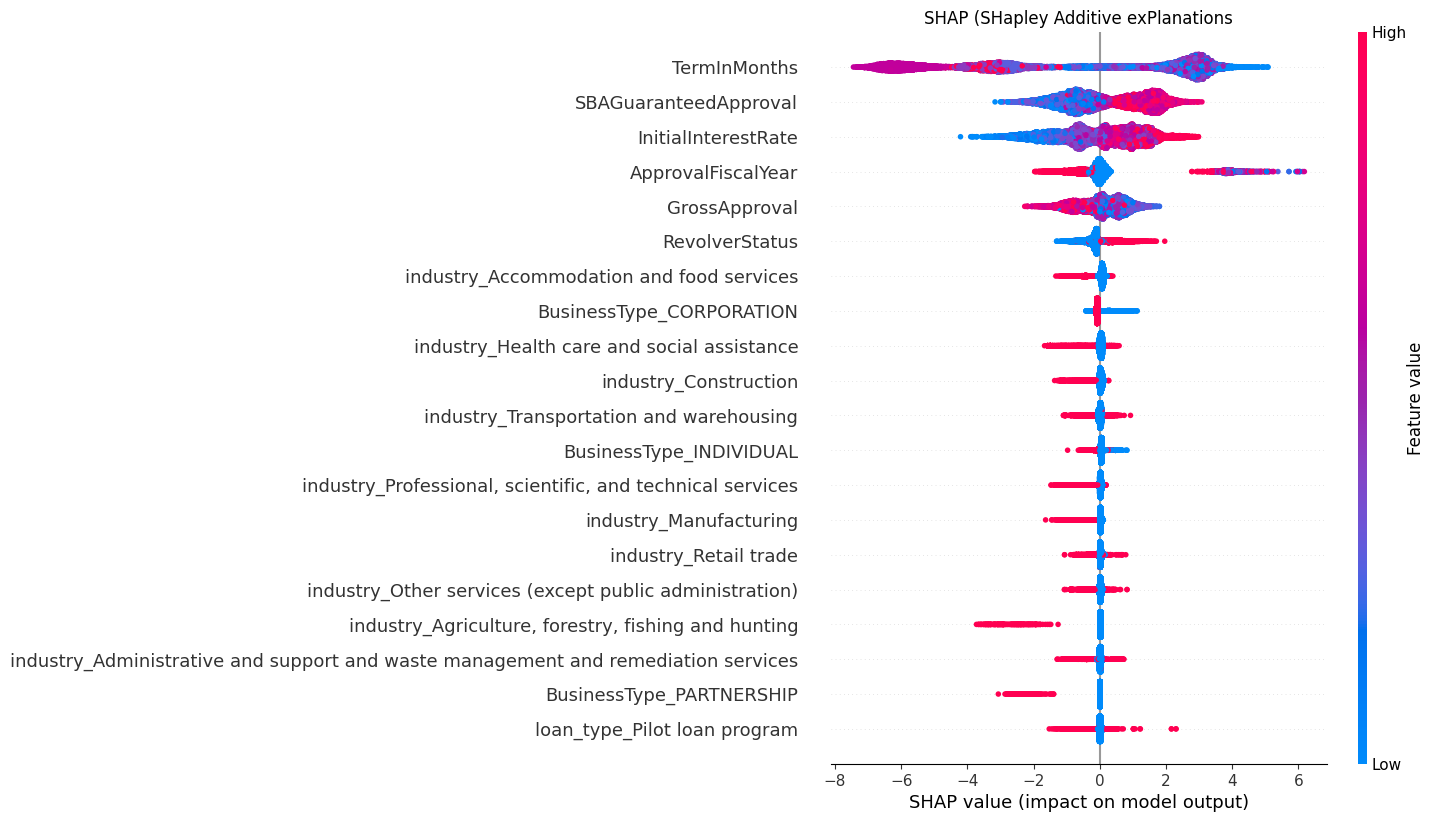

In [39]:
# SHAP (SHapley Additive exPlanations):

explainer = shap.TreeExplainer(XGB_model)
shap_values = explainer.shap_values(x_test)

# Summary plot
plt.title('SHAP (SHapley Additive exPlanations')

shap.summary_plot(shap_values, x_test)



Permutation Importance


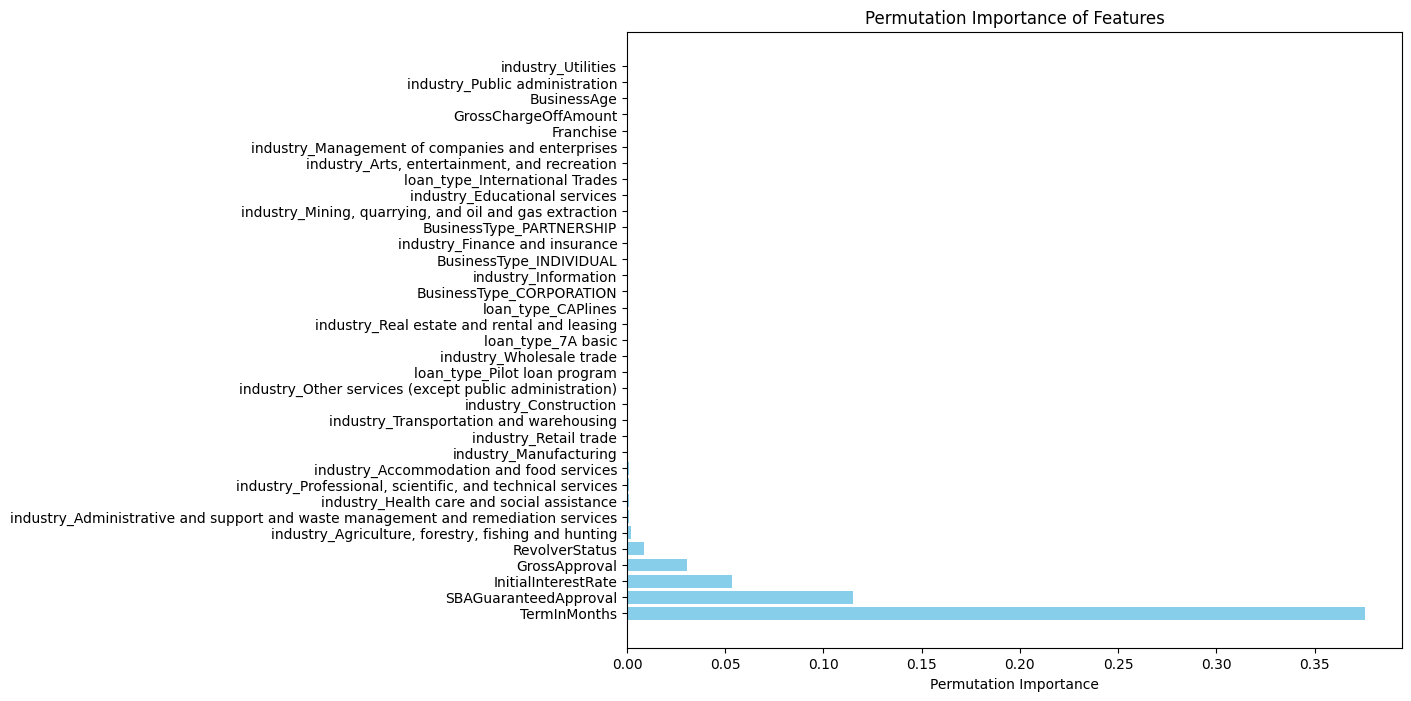

In [94]:
# Permutation Importance


# Replace model and data with your XGBoost model and data
result = permutation_importance(XGB_model, x_test, y_test, n_repeats=10, random_state=42)

# Get feature importances
importances = result.importances_mean

# Plot the importances
sorted_idx = importances.argsort()[::-1]
# Create a bar plot
plt.figure(figsize=(10, 8))
plt.barh(x_test.columns[sorted_idx], importances[sorted_idx], color='skyblue')
plt.xlabel('Permutation Importance')
plt.title('Permutation Importance of Features')
plt.show()


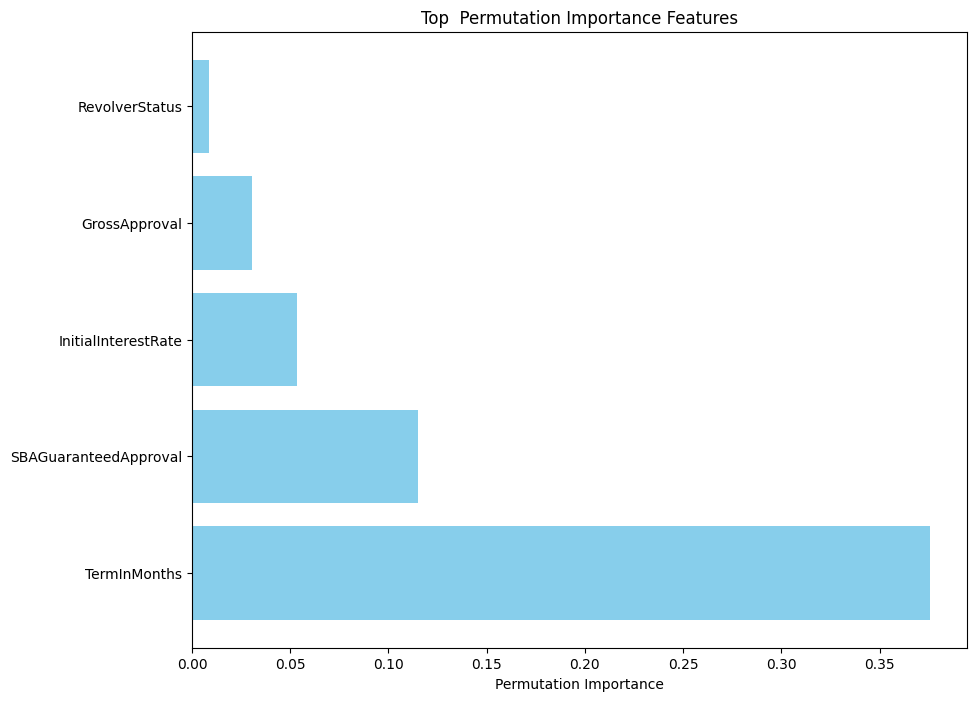

In [96]:

# Select the top  features based on permutation importance

# Plot the importances
sorted_idx = importances.argsort()[::-1][:5]
# Create a bar plot
plt.figure(figsize=(10, 8))
plt.barh(x_test.columns[sorted_idx], importances[sorted_idx], color='skyblue')
plt.xlabel('Permutation Importance')
plt.title('Top  Permutation Importance Features')
plt.show()




# remodeling

In [9]:
rdf = df[["TermInMonths", "SBAGuaranteedApproval", "InitialInterestRate", "GrossApproval", "RevolverStatus", "LoanStatus"]]

In [10]:
rdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35295 entries, 0 to 35294
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   TermInMonths           35295 non-null  float64
 1   SBAGuaranteedApproval  35295 non-null  float64
 2   InitialInterestRate    35295 non-null  float64
 3   GrossApproval          35295 non-null  float64
 4   RevolverStatus         35295 non-null  float64
 5   LoanStatus             35295 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 1.6 MB


In [13]:
srdf = smote(rdf)

Original unbalanced dataset shape 35295
Resampled balanced dataset shape 63848


In [14]:
 # Split the data into features (X) and target variable (y)
X = srdf.drop('LoanStatus', axis=1)
y = srdf['LoanStatus']

# Create the training sample
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)


In [15]:
XGB_model = XGBClassifier()
XGB_model.fit(x_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [16]:
y_pred = XGB_model.predict(x_test)

In [18]:
print('Accuracy Test : ' ,accuracy_score(y_test, y_pred) * 100)
print('F1 Score Test : ' ,f1_score(y_test, y_pred) * 100)
print('Confusion Matrix :' ,confusion_matrix(y_test, y_pred))

Accuracy Test :  96.56225528582615
F1 Score Test :  96.57673112913288
Confusion Matrix : [[12277   569]
 [  309 12385]]


# model deployment

In [20]:

# Save the model to a file
joblib.dump(XGB_model, 'xgboost_model.joblib')


['xgboost_model.joblib']